# Wing aerodynamic optimization
In this example we optimize the chord distribution of a wing using a lifting-line aerodynamic model
to recover an elliptical wing.
We also compare the performance of modern automatic differentiation to (classical) finite-differentiation.

In [1]:
import torchmdo
import torch
import matplotlib.pyplot as plt
from time import time
from pdb import set_trace
%matplotlib inline

## Model of an aircraft wing

First, create an class to define a wing and to compute its induced drag using a lifting-line model.
Note that we must inherit `torchmdo.Model` and define a `compute` method that computes all
objectives and constraints (which we'll talk about later).
In the `__init__` constructor, we initialize the wing as a square wing with constant chord.

In [2]:
class Wing(torchmdo.Model):
    def __init__(self, Cl_target: float, num_discretize: int):
        self.span = 10.0 # 10 m span
        # establish a computational grid (using the lifting line change of variables)
        self.section_endpoints = -self.span/2 * torch.cos(
            torch.linspace(torch.pi / 2, torch.pi, num_discretize + 1))
        self.section_lengths = torch.diff(self.section_endpoints)
        self.section_midpoints = (self.section_endpoints[:-1] + self.section_endpoints[1:])/2
        # initialize the chords variable which we will optimize
        self.chords =  1.0 * torch.ones_like(self.section_midpoints) # initially 1 m constant chord
        # specify that the airfoil gives zero lift at -3deg and that it is untwisted
        self.alpha_sections = torch.zeros_like(self.section_midpoints)
        self.alpha_0s = torch.deg2rad(-3.0*torch.ones_like(self.section_midpoints))
        # specify a target Cl
        self.Cl_target = torch.as_tensor(Cl_target)
        
    def compute(self) -> None:
        """ compute the induced drag coefficient for the wing. """
        # compute the wing area for the full wing (both halves)
        self.wing_area = 2*torch.sum(self.section_lengths * self.chords)
        # compute the induced drag coefficient and span efficiency factor
        wing = torchmdo.lifting_line.LiftingLineWing(
            self.section_midpoints, chords=self.chords, 
            alpha_sections=self.alpha_sections, alpha_0s=self.alpha_0s,
            span=self.span, wing_area=self.wing_area
        )
        self.Cd, self.span_efficiency_factor = wing.induced_drag(Cl=self.Cl_target)[:2]
        self.Cl_section = wing.section_lift_coeff(Cl=self.Cl_target)

Define a function to plot the wing planview.

In [3]:
def plot(wing: Wing):
    """ plot the wing assuming the spar is at 1/4 chord. """
    plt.figure(figsize=(8,3))
    plt.title("Wing planview")
    # layout right wing
    x = torch.cat([wing.section_midpoints, torch.flip(wing.section_midpoints, (0,))])
    y = torch.cat([0.25*wing.chords, -0.75*torch.flip(wing.chords, (0,))])
    # make sure the root is closed
    x[0] = x[-1] = 0.0
    # combine it with the left wing
    x = torch.cat([-torch.flip(x, (0,)), x])
    y = torch.cat([torch.flip(y.detach(), (0,)), y])
    plt.fill_between(x, y.detach(), color='k')
    plt.xlabel("Spanwise position (m)")
    plt.axis('equal')

## Optimize
Optimize the chord distribution by maximizing the span efficiency factor (equivalent to minimizing induced drag) subject to a wing area equality constraint.
Based on the parameterization we choose, this gives a $50$-dimensional optimization problem.

For setup we will arbitrarily choose a target lift coefficient of $C_L = 0.5$ and enforce the wing area to be $10 m^2$ for
this aircraft whose span is $10 m$.
Note that the maximum span efficiency factor is 1 when an elliptical lift distribution is recovered so we expect this to be
our optimal value.
Also, note that the wing area is linear in the design variables, therefore, we flag this constraint as linear.

[ 11:31:17 ] INFO: Initial objective: 0.921.
[ 11:31:17 ] INFO: Beginning optimization.
[ 11:31:17 ] INFO: niter: 0001, fun: 0.9209, constr_violation: 0, execution_time: 0.0s
[ 11:31:19 ] INFO: niter: 0010, fun: 0.9646, constr_violation: 0, execution_time: 1.2s
[ 11:31:20 ] INFO: niter: 0020, fun: 0.9985, constr_violation: 0, execution_time: 2.6s
[ 11:31:22 ] INFO: niter: 0030, fun: 0.9993, constr_violation: 1.78e-15, execution_time: 4.4s
[ 11:31:24 ] INFO: niter: 0040, fun: 0.9994, constr_violation: 1.78e-15, execution_time: 6.2s
[ 11:31:26 ] INFO: niter: 0050, fun: 0.9998, constr_violation: 0, execution_time: 8.2s
[ 11:31:27 ] INFO: niter: 0060, fun: 0.9999, constr_violation: 0, execution_time: 9.9s
[ 11:31:29 ] INFO: niter: 0070, fun: 0.9999, constr_violation: 1.78e-15, execution_time: 11.7s
[ 11:31:31 ] INFO: niter: 0080, fun: 0.9999, constr_violation: 0, execution_time: 13.4s
[ 11:31:32 ] INFO: niter: 0090, fun: 0.9999, constr_violation: 1.78e-15, execution_time: 15.0s
[ 11:31:34 

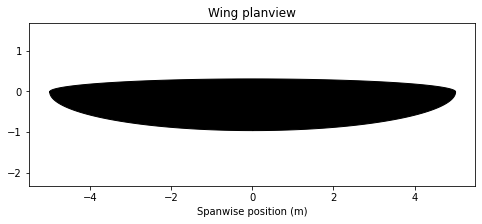

In [4]:
wing = Wing(Cl_target=0.5, num_discretize=50)
optimizer = torchmdo.Optimizer(
    initial_design_variables=[torchmdo.DesignVariable(name="chords", lower=0.)],
    compute_object=wing,
    objective=torchmdo.Maximize(name="span_efficiency_factor"),
    constraints=[
        torchmdo.Constraint(name="wing_area", lower=10.0, upper=10.0, linear=True),
    ],
)
optimizer.optimize(display_step=10)
plot(wing)

Plot the span-wise sectional lift coefficient and lift distribution over the optimized wing.
We will assume a sea-level air density ($1.21kg/m^3$),
and a flight speed of $50 m/s$.

As expected, we have recovered an elliptical lift distribution (blue), and the lift-coefficient is
constant across the wing since we have no twist and the induced downwash is constant across the 
wing for an elliptical lift distribution.

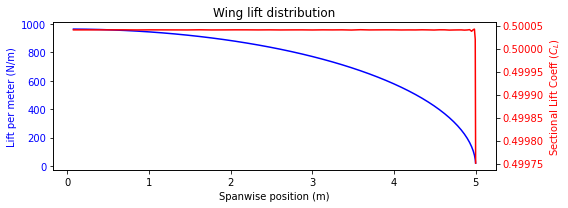

In [5]:
q = 0.5*1.21*50**2 # dynamic pressure
with torch.no_grad():
    wing.compute()
    fig, ax1 = plt.subplots(figsize=(8,3))
    ax1.set_title("Wing lift distribution")
    ax1.plot(wing.section_midpoints, wing.Cl_section*wing.chords*q, 'b')
    ax1.set_xlabel("Spanwise position (m)")
    ax1.set_ylabel("Lift per meter (N/m)", color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax2 = ax1.twinx()
    ax2.plot(wing.section_midpoints, wing.Cl_section, 'r')
    ax2.set_ylabel(r"Sectional Lift Coeff ($C_L$)", color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    fig.tight_layout() # otherwise right label is clipped

## Compare the speed to finite-difference gradients
We now compare the computation time required to compute the gradient of the objective between
PyTorch's automatic differentiation and finite-difference approximation to the gradient which
is what would be used if the gradient of the objective was not available (for example, in `scipy.optimize`).

The number of design variables are varied by considering a different discretization of wing to give a number
of design variables that vary from $10$ to $500$.
For finite differentiation, we consider a 2-step method forward or backwards method.

The results are ploted on both a linear scale and a log-log scale.
It is evident that the automatic differentiation method is much faster, particularly when there are
a large number of design variables.
For $400$ design variables, automatic differentiation is $~100x$ faster than finite differentiation.
This is because the time to compute the gradient by automatic differentiation is effectively
constant with respect to the number of design variables, assuming the cost of the objective doesn't increase
with the dimensionality.
This assumption is violated in our case; however, the favorable scaling is still evident.

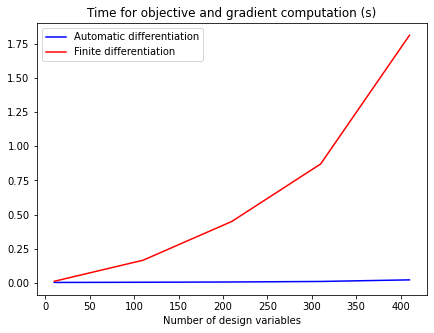

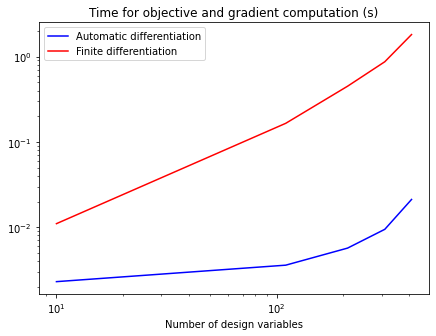

In [25]:
num_design_variables = torch.arange(10, 500, step=100)
num_trial = 10
t_finite_diff = torch.zeros((num_design_variables.numel(), num_trial))
t_auto_diff = torch.zeros((num_design_variables.numel(), num_trial))
for i,ndv in enumerate(num_design_variables):
    # setup model and optimization problem
    wing = Wing(Cl_target=0.5, num_discretize=ndv)
    optimizer = torchmdo.Optimizer(
        initial_design_variables=[torchmdo.DesignVariable(name="chords", lower=0.)],
        compute_object=wing,
        objective=torchmdo.Maximize(name="span_efficiency_factor"),
        constraints=[],
    )
    x = optimizer.variables_tensor.detach()
    # run the trials for each gradient computation
    for trial in range(num_trial):
        # time the computation of the value and gradient by autograd
        optimizer.reset_state()
        t0 = time()
        optimizer.objective_fun(x)
        optimizer.objective_grad(x)
        t_auto_diff[i, trial] = time() - t0
        # time the finite difference gradient
        # for two-step forward finite difference this requires (1 + ndv) objective evaluations
        # so we will just evaluate it once and then multiply the time by this factor
        optimizer.reset_state()
        with torch.no_grad(): # ensure no overhead
            t0 = time()
            optimizer.objective_fun(x)
            t_finite_diff[i, trial] = (time() - t0)*(1 + ndv)
# plot
for plot_type in [plt.plot, plt.loglog]:
    plt.figure(figsize=(7,5))
    plot_type(num_design_variables, t_auto_diff.mean(dim=1), 'b', label="Automatic differentiation")
    plot_type(num_design_variables, t_finite_diff.mean(dim=1), 'r', label="Finite differentiation")
    plt.legend(loc=0)
    plt.title("Time for objective and gradient computation (s)")
    plt.xlabel("Number of design variables");